## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport hapclust

In [2]:
# load data
callset_haps = np.load('../data/haps_phase1.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [3]:
# chop into gene
loc_vgsc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haps[loc_vgsc]
pos_vgsc = pos[loc_vgsc]

h_vgsc

<HaplotypeArray shape=(1713, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [4]:
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))[ :-16]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors = np.array([pop_colors[p] for p in hap_pops])

In [5]:
df_haplotypes = tbl_haplotypes.todataframe(index='index')
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [6]:
tbl_variant_labels = (
    etl
    .frompickle('../data/tbl_variants_phase1.pkl')
#     .eq('num_alleles', 2)
    .cut('POS', 'AGAP004707-RA')
    .convert('AGAP004707-RA', lambda v: v[1] if v[0] == 'NON_SYNONYMOUS_CODING' else '')
    .rename('AGAP004707-RA', 'label')
)
tbl_variant_labels

0|POS,1|label
2358254,D33N
2358316,
2358328,
2358353,
2358405,


In [7]:
len(tbl_variant_labels)

7279

In [8]:
pos2label = tbl_variant_labels.lookupone('POS', 'label')

In [9]:
pos2label[2358254], len(pos_vgsc)

('D33N', 1713)

In [10]:
variant_labels = np.array([pos2label.get(p, '') for p in pos_vgsc], dtype=object)
# variant_labels_vgsc = variant_labels[loc]
# variant_labels_vgsc[:5]
variant_labels[:5]

array(['D33N', '', '', '', ''], dtype=object)

In [11]:
pos_vgsc

0,1,2,3,4,...,1708,1709,1710,1711,1712
2358254,2358316,2358328,2358353,2358405,...,2431417,2431487,2431518,2431527,2431542


## Plot networks

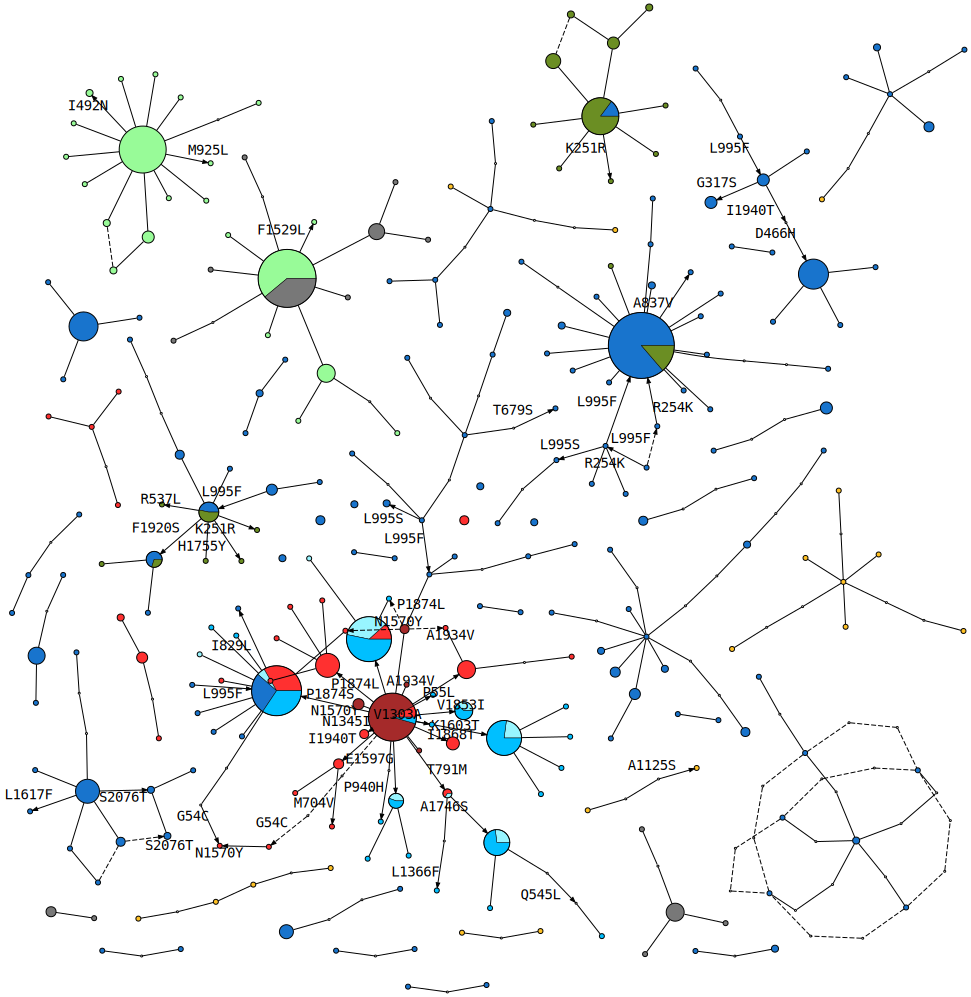

In [12]:
graph, _ = hapclust.graph_haplotype_network(
    h_vgsc, 
    network_method='msn', 
    hap_colors=hap_colors, 
    max_dist= 3, 
    variant_labels=variant_labels,
    show_singletons=False)
graph

In [13]:
pos_995S = 2422651
pos_995F = 2422652
pos_1527 = 2429617

In [14]:
loc_995S = h_vgsc[pos_vgsc.locate_key(pos_995S)] == 1
loc_995F = h_vgsc[pos_vgsc.locate_key(pos_995F)] == 1
loc_1527 = h_vgsc[pos_vgsc.locate_key(pos_1527)] == 1

In [15]:
pop_995F = df_haplotypes.population[:h_vgsc.shape[1]].iloc[loc_995F]
pop_995F.value_counts()

CMS    291
BFS    162
BFM    117
AOM    103
GNS     62
GAS     40
Name: population, dtype: int64

In [16]:
pop_995S = df_haplotypes.population[:h_vgsc.shape[1]].iloc[loc_995S]
pop_995S.value_counts()

UGS    206
CMS     85
GAS     72
KES     67
Name: population, dtype: int64

In [17]:
np.count_nonzero(loc_995F), np.count_nonzero(loc_995S), np.count_nonzero(loc_1527)

(775, 430, 19)

In [18]:
#kdr haps
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
h_vgsc_1527 = h_vgsc.compress(loc_1527, axis=1)

In [19]:
#colours
hap_colors_995F = hap_colors.compress(loc_995F)
hap_colors_995S = hap_colors.compress(loc_995S)
hap_colors_1527 = hap_colors.compress(loc_1527)

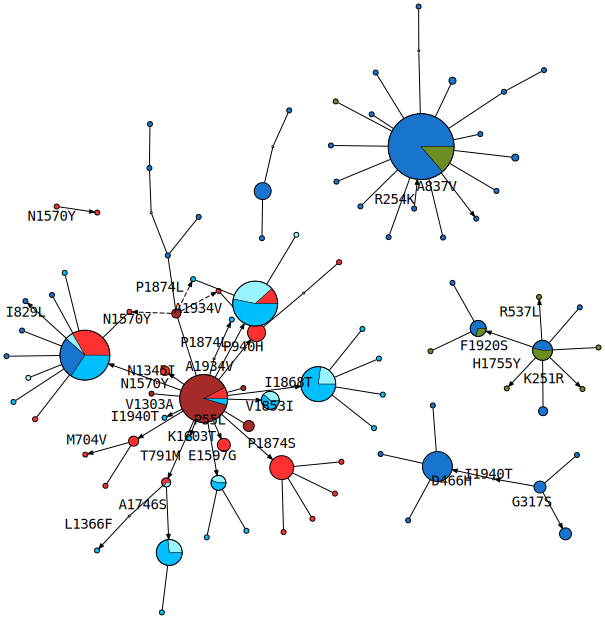

In [20]:
graph, h_distinct_sets, components = hapclust.graph_haplotype_network(
    h_vgsc_995F, 
    network_method='mjn', 
    max_dist=2, 
    hap_colors=hap_colors_995F, 
    variant_labels=variant_labels,
    return_components=True,  # new option, N.B., changes return values
    show_singletons=False,  # new option, don't show unconnected singleton nodes, makes graph less noisy
)

# graph.format = 'svg'
# fn = '../artwork/995F_clusters_mjn_maxdist2'
# graph.render(fn)

graph

In [21]:
# this tells you, for each *distinct* haplotype (i.e., node in the graph), 
# which "connected component" (i.e., cluster) it belongs to
components

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  2,  0,  2,  0,  0,  0,
        0,  0,  3,  4,  0,  5,  0,  0,  6,  7,  0,  8,  0,  9,  9, 10,  8,
        8, 10,  9, 10,  0, 10,  8,  8, 11, 12,  8, 13, 14,  9, 15,  8, 10,
       16, 17,  8, 11,  8, 18,  8,  0,  0,  0,  0,  8,  8,  8,  9,  8, 19,
       11, 20,  9,  8, 21,  9,  0, 22,  8, 23,  0,  8,  0,  0, 24, 25, 26,
       27,  0,  0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 10,  8, 10, 10,
       10, 10,  0,  0], dtype=int32)

In [22]:
# this tells you the number of distinct haplotypes for each connected component
# e.g., component 0 has 51 *distinct* haplotypes (= 51 nodes in the graph)
# e.g., component 8 has 18 *distinct* haplotypes (= 18 nodes in the graph)
np.bincount(components)

array([51,  1,  2,  1,  1,  1,  1,  1, 18,  7, 10,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [23]:
# N.B., h_distinct_sets has the set of haplotype indices for each distinct haplotype
# i.e., the set of haplotype indices for each node in the graph
# e.g., node 3 is the big N1570Y node
pop_995F.iloc[sorted(h_distinct_sets[3])].value_counts()

BFS    33
BFM    32
CMS    26
GNS     5
Name: population, dtype: int64

In [24]:
def identify_components(h_distinct_sets, components):
    """This function is designed to collect all indices for original haplotypes 
    within each connected component. I.e., it finds clusters from the network.
    It is designed to warp your mind."""
    clusters = []
    for c in np.unique(components):
        cluster = set()
        for i in np.nonzero(components == c)[0]:
            cluster |= h_distinct_sets[i]
        clusters.append(sorted(cluster))
    return clusters

In [25]:
clusters = identify_components(h_distinct_sets, components)

In [26]:
# here is F1
pop_995F.iloc[clusters[0]].value_counts()

BFS    161
BFM    110
AOM     89
GNS     62
CMS     34
Name: population, dtype: int64

In [27]:
# here is the bigger CMS/GAS cluster
pop_995F.iloc[clusters[8]].value_counts()

CMS    163
GAS     24
Name: population, dtype: int64

In [28]:
# etc.
pop_995F.iloc[clusters[9]].value_counts()

CMS    50
Name: population, dtype: int64

In [29]:
pop_995F.iloc[clusters[10]].value_counts()

CMS    19
GAS    16
Name: population, dtype: int64

In [30]:
pop_995F.iloc[clusters[11]].value_counts()

CMS    13
Name: population, dtype: int64

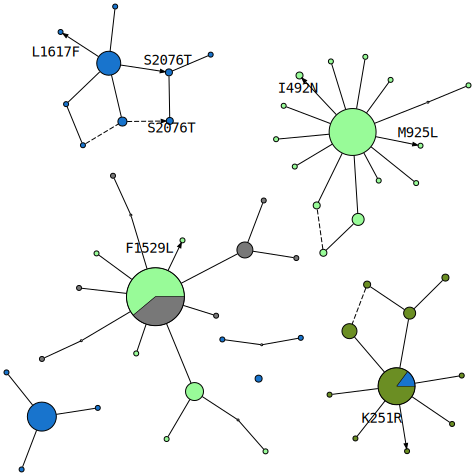

In [31]:
graph, hapcount = hapclust.graph_haplotype_network(
    h_vgsc_995S, 
    network_method='mjn', 
    max_dist=2, 
    hap_colors=hap_colors_995S, 
    variant_labels=variant_labels,
    show_singletons=False)

graph.format = 'svg'
fn = '../artwork/995S_clusters_mjn_maxdist2'
graph.render(fn)

graph

In [32]:
pos_vgsc.shape

(1713,)

In [33]:
h_vgsc_1527.shape

(1713, 19)

In [34]:
pos_1527

2429617

In [35]:
pos_402 = 2391228

In [36]:
pos_vgsc.locate_key(pos_402)

838

In [37]:
variant_labels[838]

'V402L'

In [38]:
pos_vgsc.locate_key(pos_1527)

1671

In [39]:
variant_labels[1671]

'I1527T'

In [40]:
h_vgsc_1527[838]

array([2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1], dtype=int8)

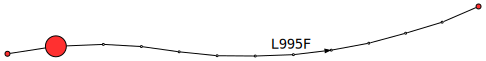

In [41]:
# There is a recombination event just upstream of SNP 970; if 
# exclude upstream flank then get a single network (more-or-less)

loc_spike = slice(970, -100)

graph, hapcount = hapclust.graph_haplotype_network(
    h_vgsc_1527[loc_spike], 
    network_method='mjn', 
    max_dist=20, 
    hap_colors=hap_colors_1527, 
    variant_labels=variant_labels[loc_spike],
)

# graph.format = 'svg'
# fn = '../artwork/1527_clusters_mjn_maxdist2'
# graph.render(fn)

graph

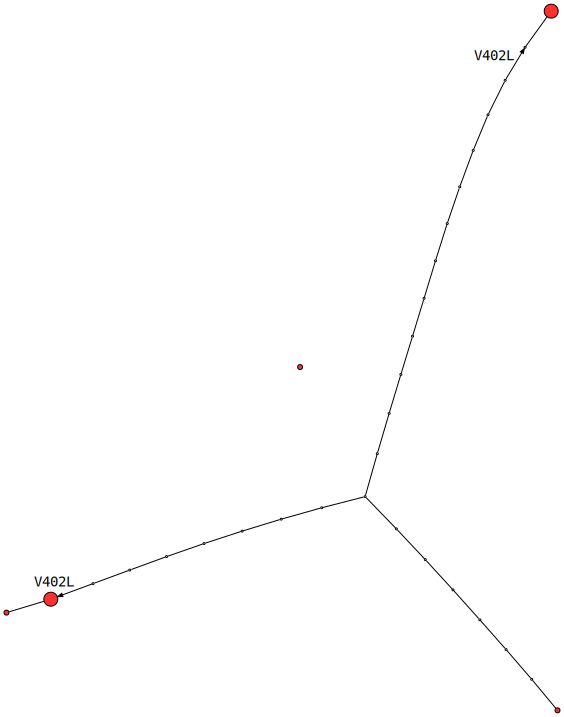

In [42]:
# There is a recombination event just upstream of SNP 970; if 
# include upstream flank then get two networks, one with each 
# of the V402L variants (more-or-less)
loc_spike = slice(830, -100)

graph, hapcount = hapclust.graph_haplotype_network(
    h_vgsc_1527[loc_spike], 
    network_method='mjn', 
    max_dist=20, 
    hap_colors=hap_colors_1527, 
    variant_labels=variant_labels[loc_spike],
)

# graph.format = 'svg'
# fn = '../artwork/1527_clusters_mjn_maxdist2'
# graph.render(fn)

graph